In [79]:
import gurobipy
import numpy as np
import matplotlib.pyplot as plt
import numpy as np 
import random
import pandas as pd

In [86]:
#Set random seed
rnd = np.random
rnd.seed(0)
#A = [(i,j) for i in V for j in V if i != j]
#c = {(i,j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i,j in A}
#Q = 20
#q = {i: rnd.randint(1,10) for i in N}



In [87]:
from gurobipy import Model, GRB, quicksum
mdl = Model("CVRP")
#sets
K = [i for i in range(1,3+1)] #Products
T = [i for i in range(1,10+1)] #Periods
L = [i for i in range(1,3+1)] #Vendor
R = [i for i in range(1,3+1)] # Menge der Rabattstufen


#Parameter
bigM_N_tk = 100000
bigM_RF_tk = 1000000

c_N = round(random.random()*100,2)
c_RF = round(random.random()*100,2)

d_N_kt = oc_fix_lr = [[round(random.randint(2,10),2) \
                       for i in range(len(T))] for j in range(len(K))]

d_RF_kt = oc_fix_lr = [[round(random.randint(2,10),2) \
                       for i in range(len(T))] for j in range(len(K))]

#Emission
e_N = round(random.random()*10,2)
e_RF = round(random.random()*10,2)
e__max = round(random.random()*10,2)

#storage cost
l_N_k = np.round(rnd.rand(len(K)), 2) 
l_R_k = np.round(rnd.rand(len(K)), 2) 
l_RF_k = np.round(rnd.rand(len(K)), 2) 
l_M = np.round(rnd.rand(len(K)), 2) 


p_k = np.round(rnd.rand(len(K)), 2) 
pt_N_k = np.round(rnd.rand(len(K)), 2) 
pt_RF_k = np.round(rnd.rand(len(K)), 2) 

#returned goods amount
re_kt = [[round(random.randint(2,10),2) \
                       for i in range(len(T))] for j in range(len(K))]
#setup cost
sc_N_k = pt_RF_k = np.round(rnd.rand(len(K)), 2) 
sc_RF_k = pt_RF_k = np.round(rnd.rand(len(K)), 2) 

#setupcost
st_N_k = np.round(rnd.rand(len(K)), 2) 
st_RF_k = np.round(rnd.rand(len(K)), 2) 

#setuptime
sc_N_k = np.round(rnd.rand(len(K)), 2) 
sc_RF_k = np.round(rnd.rand(len(K)), 2) 

#material demand
mb_N_k = np.round(rnd.rand(len(K)), 2) 
mb_RF_k = np.round(rnd.rand(len(K)), 2) 

#ordering cost
oc_fix_lr = [[round(random.random()*10,2) for i in range(len(L))] for j in range(len(R))]
oc_var_lr = [[round(random.random(),2) for i in range(len(L))] for j in range(len(R))]

#trash/disposal cost
tc = round(random.random()*10,2)

#substitution cost
c_sub = round(random.random()*10,2)





In [85]:
re_kt

[[6, 10, 8, 3, 6, 6, 6, 9, 4, 10],
 [7, 5, 8, 4, 7, 6, 5, 2, 2, 10],
 [3, 6, 5, 9, 9, 9, 6, 10, 4, 5]]

In [80]:
pd.DataFrame(oc_fix_lr)

0     1     2
0  0.05  1.46  5.03
1  1.68  2.87  8.33
2  2.30  1.14  1.19

In [81]:
pd.DataFrame(d_N_kt)

0  1  2  3  4  5  6   7  8  9
0  2  9  8  8  9  4  6  10  8  9
1  5  6  7  2  2  2  4   5  8  9
2  4  9  8  4  7  9  7   3  6  7

([<matplotlib.axis.XTick at 0x1defce5a460>,
 [Text(0, 0, 'Period 0'),
  Text(1, 0, 'Period 1'),
  Text(2, 0, 'Period 2'),
  Text(3, 0, 'Period 3'),
  Text(4, 0, 'Period 4'),
  Text(5, 0, 'Period 5'),
  Text(6, 0, 'Period 6'),
  Text(7, 0, 'Period 7'),
  Text(8, 0, 'Period 8'),
  Text(9, 0, 'Period 9')])

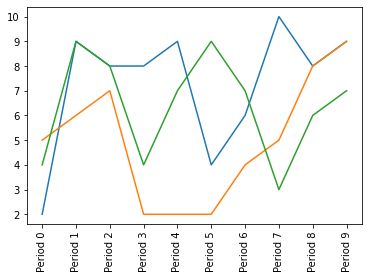

In [77]:
for counter, r in enumerate(d_N_kt):
    plt.plot(range(0,len(r)), r, label = f"line {counter}")  

plt.xticks(range(0,len(r)), [f"Period {i}" for i in  range(0,len(r))] , rotation = 'vertical')

In [75]:
oc_var_lr

[[0.48, 0.83, 0.7], [0.15, 0.99, 0.35], [0.19, 0.72, 0.42]]

In [46]:
#Variablen
X_N_kt = 0
X_RF_kt = 0

#setup-variables
gamma_N_kt = mdl.addVars(A, vtype=GRB.BINARY)
gamme_RF_kt = mdl.addVars(A, vtype=GRB.BINARY)

#Storage-quantity
Y_N_kt = mdl.addVars(N, vtype=GRB.CONTINUOUS) # new goods
Y_RF_kt = mdl.addVars(N, vtype=GRB.CONTINUOUS) #remanufactured goods
Y_M_t = mdl.addVars(N, vtype=GRB.CONTINUOUS) #raw material

#Substitution quantity
S_kt = mdl.addVars(N, vtype=GRB.CONTINUOUS)
#disposal quantity
A_t = mdl.addVars(N, vtype=GRB.CONTINUOUS)

x = mdl.addVars(A, vtype=GRB.BINARY)
u = mdl.addVars(N, vtype=GRB.CONTINUOUS)

\begin{align}
	Min. Z= \sum_{k \epsilon K} \sum_{t \epsilon T} ( p_{k} [\, X_{kt}^N + X_{kt}^{RF}] \,  +   sc_{k}^{N} \, \gamma_{kt}^{N} + sc_{k}^{RF} \, \gamma_{kt}^{RF} ) \notag\\ + \sum_{k \epsilon K} \sum_{t \epsilon T} l^{N}_{k} \, Y_{kt}^{N} +l^{RF}_{k} \, Y_{kt}^{RF}  + l^{R}_{k}  \, Y_{kt}^{R}  + c^{sub} S_{kt})  
	+ \sum_{t \epsilon T}( l^M \, 
	Y_t^M + tc \, A_t) \notag\\ + \sum_{l \epsilon L} \sum_{r \epsilon R} \sum_{t \epsilon T}(  \beta_{lrt} \, oc_{lr}^{fix} +  B_{lrt} \, oc_{lr}^{var}) 
		\label{Eq:ZFkt}
\end{align}

\begin{align}
	& Y^{R}_{k,t-1} + re_{kt} - X^{RF}_{kt} - A_t = Y^{R}_{kt} \, & & \forall \, k \in \mathcal{K},\,t \in \mathcal{T} &\hfill \label{Lagerbilanz_Rücklauf}\\[2ex]
\end{align}

\begin{align}
	\hspace{12pt}&Y^{M}_{t-1} + \sum_{l \in \mathcal{L}} \sum_{r \in \mathcal{R}} B_{l,r,t} - \sum_{k \in \mathcal{K}} (mb^{N}_{k} \cdot X^{N}_{kt} + mb^{RF}_{k} \cdot X^{RF}_{kt}) = Y^{M}_{t} \,& &\forall \, t \in \mathcal{T} &\hfill \label{Eq:Lagerbilanz_Material}\\[2ex]
\end{align}

\begin{align}
	Y^{R}_{k,t-1} + re_{kt} - X^{RF}_{kt} - A_t = Y^{R}_{kt} \, & & \forall \, k \in \mathcal{K},\,t \in \mathcal{T} &\hfill \label{Lagerbilanz_Rücklauf}\\[2ex]
\end{align}

\begin{align}
	Y^{N}_{k,t-1}  + X^{N}_{kt} - d_{kt}^N - S_{kt} = Y^{N}_{kt} \, & & \forall \, k \in \mathcal{K} ,t \in \mathcal{T} &\hfill \label{Eq:Lagerbilanz_Neuproduktion}\\[2ex]
\end{align}

\begin{align}
	&Y^{RF}_{k,t-1}  + X^{RF}_{kt} - d_{kt}^{RF} + S_{kt} = Y^{RF}_{kt} \, & & \forall \, k \in \mathcal{K} ,t \in \mathcal{T} &\hfill \label{Eq:Lagerbilanz_Refabrikate}\\[2ex]
\end{align}

\begin{align}
		\sum_{k \in \mathcal{K}}( st^{N}_{k} \cdot \gamma^{N}_{kt}  + pt^N \cdot X^N_{kt}) \leq c^{N}  \, & & \forall \, t \in \mathcal{T} &\hfill \label{Eq:Kapa_Neuproduktion}\\[2ex]
\end{align}

\begin{align}
		\sum_{k \in \mathcal{K}}( st^{RF}_{k} \cdot \gamma^{RF}_{kt}  + pt^{RF} \cdot X^{RF}_{kt}) \leq c^{RF}  \, & & \forall \, t \in \mathcal{T} &\hfill \label{Eq:Kapa_Refabrikation}\\[2ex]
\end{align}

\begin{align}
		X^N_{kt} \leq bigM_{kt}^{N} \cdot \gamma^{N}_{kt}  \;\;\;( BigM^N_{kt} = \sum_{t^{'}=t}^T d_{k,t^{'}}^N )\, & & \forall \,k \in \mathcal{K}\,, t \in \mathcal{T} &\hfill \label{Eq:bigM_Neuproduktion}\\[2ex]
\end{align}

\begin{align}
		X^{RF}_{kt} \leq bigM_{kt}^{RF}  \cdot \gamma^{RF}_{kt} \;\;\; (BigM^{RF}_{kt} = \sum_{t^{'}=t}^T d_{k,t^{'}}^{RF} )\, & & \forall \, k \in \mathcal{K}\,, t \in \mathcal{T} &\hfill \label{Eq:bigM_Refabrikation}\\[2ex]
\end{align}

\begin{align}
		\sum_{k \in \mathcal{K}}  (e^{N} \cdot X^{N}_{kt}  + e^{RF} \cdot X^{RF}_{kt}) \leq e^{max} \,\,\, \forall \, t \in \mathcal{T}  \, & &  &\hfill \label{Eq:Emission}\\[2ex]
\end{align}

\begin{align}
		\sum_{k \in \mathcal{K}} \sum_{t \in \mathcal{T}} e^{N} \cdot X^{N}_{kt}  + e^{RF} \cdot X^{RF}_{kt} \leq e^{max} \cdot \mathcal{T} \, & &  &\hfill \label{Eq:Emission}\\[2ex]
\end{align}

\begin{align}
    B_{lrt} \leq \beta_{lrt} \cdot oq^{max}_{lr}    \, & & \forall \, t,l,r \in \mathcal{T,L,R} &\hfill \label{Eq:Bestell-UB}\\[2ex]
\end{align}

\begin{align}
B_{lrt} \geq \beta_{lrt} \cdot(1+ oq^{max}_{lr-1})    \, & & \forall \,t,l,r \in \mathcal{T,L,R} &\hfill \label{Eq:Bestell-LB}\\[2ex]
\end{align}

\begin{align}
\sum_{r \in \mathcal{R}} \beta_{lrt}  \leq 1   \, & & \forall \, l \in \mathcal{L}\,, t \in \mathcal{T}  &\hfill \label{Eq:Bestell-nur-über-eine-Rabattstufe}\\[2ex]
\end{align}

\begin{align}
    A_t, B_{lrt} , X^{N}_{kt} , X^{RF}_{kt} , Y^{M}_{t} ,  Y^{N}_{kt} , Y^{RF}_{kt} ,  Y^{R}_{kt} \geq 0  \, & & \forall \, t \in \mathcal{T} &\hfill \label{Eq:NNB}\\[2ex]
\end{align}

\begin{align}
    \beta_{lrt} ,  \gamma^{N}_{kt} , 	\gamma^{RF}_{kt} \in \lbrace 0,1 \rbrace	  \, & & \forall \, t \in \mathcal{T} &\hfill \label{Eq:Binär}
\end{align}